# CS 448 Project: Audio Intent Classification with Sentiment Analysis (Emotion Classifier)

By Chandana (chandan4)

Intial Proposal and Motivation:

Audio intent Classification is much needed in interactive voice response (IVR), understanding the intent and sentiment behind customer inquiries is crucial for enhancing service quality and satisfaction. This project proposes the development of a voice intent classification and sentiment analysis system tailored to process customer voice interactions. By leveraging state-of-the-art audio computing and natural language processing (NLP) technologies, this system aims to accurately interpret the customer's intent and sentiment from audio interactions, providing actionable insights to improve response strategies and customer experience.

As of now, my plan is to achieve Audio Intent classification using data like Skit-S2I Dataset which is a dataset for Intent classification from the Banking domain as part of query understanding process. Then as second part of the project I would like to add sentiment analysis to the voice to understand the customer’s mood and take the informed decision this can be a useful feature in the IVR process.

In [ ]:
#Dependencies
!pip install SpeechRecognition
!pip install np_utils
!pip install noisereduce
!pip install tqdm
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [13]:
#Loading Libraries
import numpy as np
import pandas as pd
import matplotlib .pyplot as plt
import scipy.io.wavfile
import IPython, random, os,sys, librosa, librosa.display
import seaborn as sns
from itertools import cycle


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
import np_utils
from keras.callbacks import ModelCheckpoint

from IPython.display import display, Audio, HTML
from glob import glob
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

import speech_recognition as sr

## Mounting Audio Speech-to-Intent DataSet:

For the audio-intent classification I have used a Skit-S2I Dataset, that consists 16K audio wav files for training and 1400 wav files for testing. The dataset isfor Intent classification from human speech, and covers 14 coarse-grained intents from the Banking domain. The audio files used here are the conversations of 11 speakers with customer service agents. It has information on speaker and the business intent as well for audio_intent classification.

In [14]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!ls "/content/drive/My Drive/Datasets/speech-to-intent_dataset.zip"

'/content/drive/My Drive/Datasets/speech-to-intent_dataset.zip'


In [ ]:
!unzip "/content/drive/My Drive/Datasets/speech-to-intent_dataset.zip" -d "/content/"

## Exploring the Dataset:

Here, I am retrieving the information available in the dataset. Exploring csv files and finding information useful for audio-intent classification. Having intent dictionary helps in ease of categorization and further analysis and monitoring in customer analytics.

In [17]:


df_intent = pd.read_csv('/content/speech-to-intent/intent_info.csv')
df_intent


,intent_class,intent_name,description
0,0,branch_address,enquiry about bank branch location
1,1,activate_card,enquiry about activating card products
2,2,past_transactions,enquiry about past transactions in a specific ...
3,3,dispatch_status,enquiry about the dispatch status of card prod...
4,4,outstanding_balance,enquiry about outstanding balance on card prod...
5,5,card_issue,report about an issue with using card products
6,6,ifsc_code,enquiry about IFSC code of bank branch
7,7,generate_pin,enquiry about changing or generating a new pin...
8,8,unauthorised_transaction,report about an unauthorised or fraudulent tra...
9,9,loan_query,enquiry about different kinds of loans


In [18]:
df_speaker = pd.read_csv('/content/speech-to-intent/speaker_info.csv')
df_speaker

,speaker_id,native_language,languages_spoken,places_lived,gender
0,1,Hindi,"[""Hindi"", ""English""]","[""Patna/Bihar""]",Male
1,2,Bengali,"[""English"", ""Hindi"", ""Bengali"", ""Odia""]","[""Puri/Odisha""]",Female
2,3,Kannada,"[""English"", ""Kannada""]","[""Davanagere/Karnataka""]",Female
3,4,Hindi,"[""English"", ""Odia""]","[""Cuttack/Odisha"", ""Kolkata/West Bengal""]",Female
4,5,Punjabi,"[""English"", ""Hindi"", ""Punjabi""]","[""Jalandhar/Punjab""]",Female
5,6,Bengali,"[""Bengali"", ""English"", ""Hindi""]","[""Kolkata/West Bengal""]",Female
6,7,Malayalam,"[""English"", ""Malayalam""]","[""Kollam/Kerala""]",Female
7,8,Kannada,"[""Kannada"", ""English""]","[""Mysore/Karnataka""]",Male
8,9,Hindi,"[""Hindi"", ""English"", ""Bengali"", ""Bihari""]","[""Kolkata/West Bengal""]",Female
9,10,Hindi,"[""Hindi"", ""English""]","[""Ranchi/Jharkhand""]",Male


# Audio Analysis:

Performing analysis on the audio provided. Beginning with displaying 2 audio in random out of 1400 audio .wav files. Initially, I am selecting 2 random audio files from the audio directory in the dataset and reading and displaying the audio - The audios shows the queries asked by the customers related to banking.

Later, I grouped the audio files based on speaker MFCC features and plotted the cluster distribution by using K-Means Clustering model.

### a) Displaying 2 random audio samples

From the mounted Dataset, I tried to retrieve two audio files and displayed it here


In [19]:
def sound( x, rate=8000, label=''):
    display( HTML(
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label +
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

In [20]:
def random_audio_disp(audio_folder, n=2):
    files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.wav')]
    if len(files) < n:
        print("Not enough files to sample from.")
        return
    selected_files = random.sample(files, n)
    for file in selected_files:
        rate, x = scipy.io.wavfile.read(file)
        sound(x, rate, label=f'Playing: {os.path.basename(file)}')


audio_folder = '/content/speech-to-intent/wav_audios'
random_audio_disp(audio_folder)


Playing: 5376ac35-077f-4824-9494-d52e4fcbec16.wav


Playing: 6934bf97-a01b-40ac-ba44-63659a6801e6.wav


### b) Speaker Similarity clusters using MFCC and KMeans

Next, I am grouping all the audio files that belong to a certain user in the dataset as this information is missing. I am incorporating feature extraction technique to do this I am using MFCC and KMeans Clustering.

I clustered audio files based on their features, extracted using the MFCC (Mel-frequency cepstral coefficients) method. Initially, it loads all .wav audio files from a specified directory, computes the MFCCs for each file, and then calculates the mean of these coefficients across time to represent each audio file as a single feature vector. These features are normalized using a standard scaler and then clustered into 11 groups using the k-means clustering algorithm.

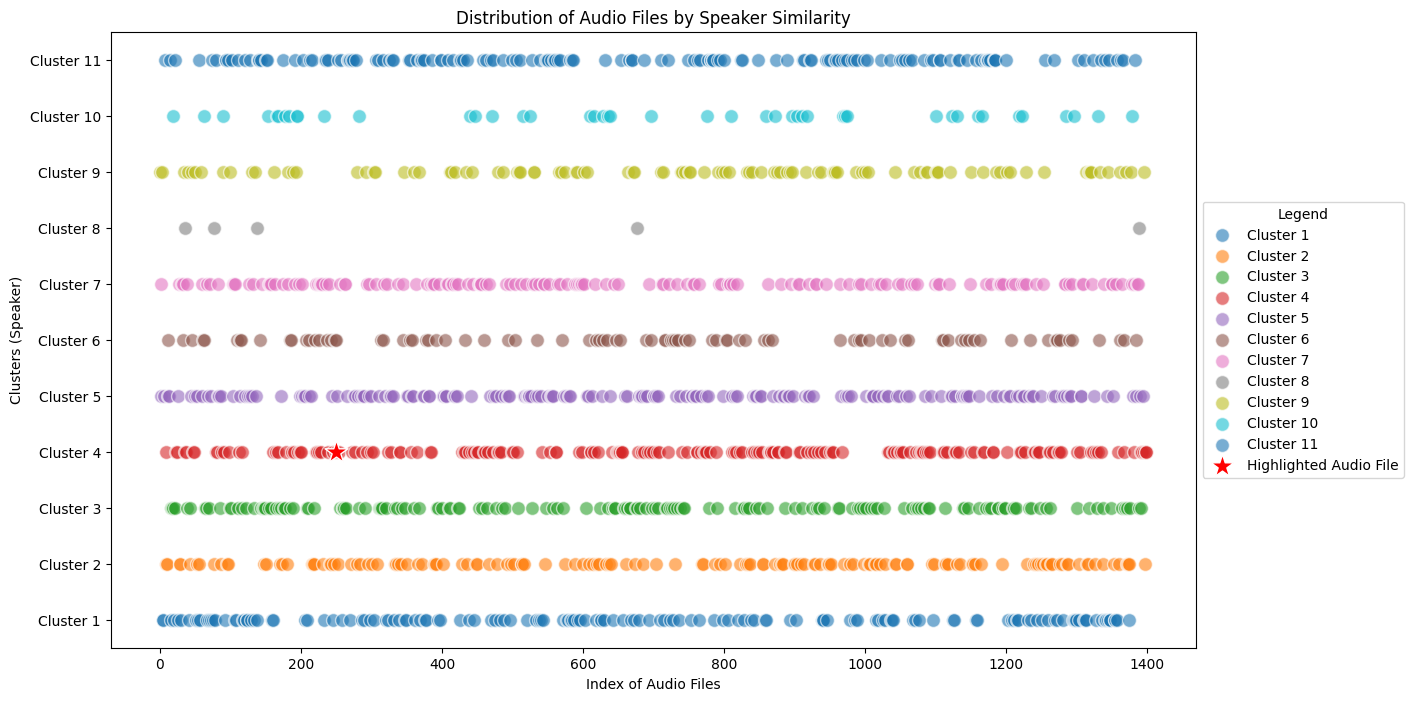

In [21]:
file_paths = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.wav')]
features = []

for path in file_paths:
    audio, sr = librosa.load(path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr)
    mfccs_mean = np.mean(mfccs, axis=1)
    features.append(mfccs_mean)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(14, 8))
for i in range(n_clusters):
    indices = np.where(labels == i)[0]
    plt.scatter(indices, [i] * len(indices), label=f'Cluster {i+1}', alpha=0.6, edgecolors='w', s=100)
# Highlight a 250th Audio file
highlight_index = 250
highlight_cluster = labels[highlight_index]
plt.scatter([highlight_index], [highlight_cluster], color='red', marker='*', s=300, edgecolors='w', label='Highlighted Audio File')
plt.yticks(np.arange(n_clusters), [f'Cluster {i+1}' for i in range(n_clusters)])
plt.xlabel('Index of Audio Files')
plt.ylabel('Clusters (Speaker)')
plt.title('Distribution of Audio Files by Speaker Similarity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
plt.show()


The graph shows the distribution of audio files by speaker similarity. Each point on the graph represents an audio file, and its position on the y-axis indicates the cluster it belongs to. The clusters are determined using the K-means clustering algorithm, which groups together audio files that have similar features.

The graph shows that there are 11 clusters of audio files, which corresponds to the 11 speakers in the dataset. The audio files for each speaker are grouped together in the same cluster, which indicates that the features of the audio files for each speaker are similar. This is likely because the speakers have similar vocal characteristics, such as accent, pitch, and voice quality.

The graph also shows that there is some overlap between the clusters. This means that some of the audio files for different speakers have similar features. This is likely because some of the speakers have similar vocal characteristics, or because some of the audio files were recorded in similar environments.

I have highlighted the 250th audio sample that belongs to cluster_id (person) = 3

##Audio Intent Classification:

Tried to see the information of train.csv, which has intent class for each associated audio file. The 'template' is the speech to text translation of the audio file. This is used as training the model for intent classification. I also grouped the same intent together to understand the distribution.

Initially, I am trying to train the model with the training dataset for intent classification.



In [ ]:
!unzip "/content/drive/My Drive/Datasets/train_audio_dataset.zip" -d "/content/"

In [37]:
df_train = pd.read_csv("/content/train_audio_dataset/train.csv")
df_train.head(10)


,id,intent_class,template,audio_path,speaker_id
0,ebe79660-102e-48c8-9e69-17ebcb72b453,6,Please tell me the IFSC Code,wav_audios/ebe79660-102e-48c8-9e69-17ebcb72b45...,3
1,e447d0f1-b6f6-4a88-ab1d-7d9f910fef64,7,Credit card pin generation,wav_audios/e447d0f1-b6f6-4a88-ab1d-7d9f910fef6...,11
2,ade30eab-c8b5-4a59-b2a3-00b0f0ebd342,3,Is my card dispatched?,wav_audios/ade30eab-c8b5-4a59-b2a3-00b0f0ebd34...,5
3,0976fa35-879b-415a-8077-d1257740ee47,11,I want to change the limit of my online transa...,wav_audios/0976fa35-879b-415a-8077-d1257740ee4...,11
4,a3c3ac82-53fb-4264-8f06-903a65b836af,8,Amount deducted from account without my knowledge,wav_audios/a3c3ac82-53fb-4264-8f06-903a65b836a...,3
5,5c83c28b-d8aa-4bfc-9721-8523fcdf77a1,0,Where is the bank branch ?,wav_audios/5c83c28b-d8aa-4bfc-9721-8523fcdf77a...,3
6,8f14c790-2110-40e3-95e9-daa5484e608d,13,I want to report my lost debit card,wav_audios/8f14c790-2110-40e3-95e9-daa5484e608...,2
7,14d2d1ef-9627-425b-86c9-7b5e9fc88baf,3,Is my card dispatched?,wav_audios/14d2d1ef-9627-425b-86c9-7b5e9fc88ba...,11
8,187446f8-77e5-474d-a307-9866f35ec7e5,4,Give me the outstanding balance on my credit card,wav_audios/187446f8-77e5-474d-a307-9866f35ec7e...,2
9,3cac1716-7d8e-4ff8-9241-bfe9f840c6a7,7,Debit card pin generation,wav_audios/3cac1716-7d8e-4ff8-9241-bfe9f840c6a...,11


In [38]:
intent_count = df_train.groupby('intent_class').size().reset_index(name='count')
print(intent_count)


    intent_class  count
0              0    773
1              1    799
2              2    732
3              3    697
4              4    740
5              5    668
6              6    780
7              7    739
8              8    956
9              9    687
10            10    746
11            11    654
12            12    684
13            13    790


In [39]:

df_intent0 = df_train[df_train['intent_class'] == 0]
df_intent1 = df_train[df_train['intent_class'] == 1]
df_intent2 = df_train[df_train['intent_class'] == 2]
df_intent3 = df_train[df_train['intent_class'] == 3]
df_intent4 = df_train[df_train['intent_class'] == 4]
df_intent5 = df_train[df_train['intent_class'] == 5]
df_intent6 = df_train[df_train['intent_class'] == 6]
df_intent7 = df_train[df_train['intent_class'] == 7]
df_intent8 = df_train[df_train['intent_class'] == 8]
df_intent9 = df_train[df_train['intent_class'] == 9]
df_intent10 = df_train[df_train['intent_class'] == 10]
df_intent11 = df_train[df_train['intent_class'] == 11]
df_intent12 = df_train[df_train['intent_class'] == 12]
df_intent13 = df_train[df_train['intent_class'] == 13]
df_intent0.head()


,id,intent_class,template,audio_path,speaker_id
5,5c83c28b-d8aa-4bfc-9721-8523fcdf77a1,0,Where is the bank branch ?,wav_audios/5c83c28b-d8aa-4bfc-9721-8523fcdf77a...,3
33,d295b403-99d8-41c9-8c65-9e560b83b9cf,0,Please tell me the nearest branch of the bank,wav_audios/d295b403-99d8-41c9-8c65-9e560b83b9c...,10
58,ceaad2d4-7c39-4de5-9870-137ad31056b5,0,What is the nearest branch?,wav_audios/ceaad2d4-7c39-4de5-9870-137ad31056b...,2
59,33f88f33-dd28-4efe-b8d4-e92302a5b024,0,Where is the bank branch ?,wav_audios/33f88f33-dd28-4efe-b8d4-e92302a5b02...,5
62,e7ff1267-7e2e-4976-92de-4bb5ce2fd35b,0,Where is the branch located?,wav_audios/e7ff1267-7e2e-4976-92de-4bb5ce2fd35...,8


###Training the Model:

Designed custom model for intent classification using the training dataset by tokenizing, TfidfVectorizer.

Processed and Analyzed a dataset for intent classification. It begins by loading the data from a CSV file and applied preprocessing steps including tokenization, lemmatization, and removal of stop words to clean the data. Furthermore, spliting the cleaned data into training and testing sets, uses TF-IDF vectorization to convert text in train.csv into numerical features, and trained using a Logistic Regression model on these features. Finally, evaluated the model's performance on the test set, providing metrics that reflect how well the model can classify new, unseen audio data into predefined intent categories. This is how audio intent classification is achieved

In [40]:
data = pd.read_csv('/content/train_audio_dataset/train.csv')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    tokens = nltk.word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]
    return " ".join(filtered_words)

data['processed_template'] = data['template'].apply(preprocess_text)
X_train, X_test, y_train, y_test = train_test_split(data['processed_template'], data['intent_class'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Training a Logistic Regression model
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_vectors, y_train)

# Predicting and evaluating the model
predictions = classifier.predict(X_test_vectors)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00       151
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       138
           4       1.00      1.00      1.00       174
           5       1.00      1.00      1.00       134
           6       1.00      1.00      1.00       176
           7       1.00      1.00      1.00       140
           8       1.00      1.00      1.00       200
           9       1.00      1.00      1.00       125
          10       1.00      1.00      1.00       157
          11       1.00      1.00      1.00       114
          12       1.00      1.00      1.00       134
          13       1.00      1.00      1.00       171

    accuracy                           1.00      2089
   macro avg       1.00      1.00      1.00      2089
weighted avg       1.00      1.00      1.00      2089



###Testing the model:

Testing on audio sources, converting them to text and finding the intent.

Proceeded with intent prediction. Using speech_recognition lib to transcribe audio into text and then applies a text preprocessing, followed by a trained TF-IDF vectorizer and a logistic regression classifier to predicted the intent. Additionally, read audio data. Below I am showing 2 examples on how it works.

In [41]:
import speech_recognition as sr
import scipy.io.wavfile as wavfile

def predict_intent(new_template):
    processed_template = preprocess_text(new_template)
    new_template_vector = vectorizer.transform([processed_template])
    intent_class = classifier.predict(new_template_vector)
    return intent_class

def predict_intent_from_audio(audio_file_path):
    r = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio = r.record(source)
        rate, x = scipy.io.wavfile.read(audio_file_path)
        sound(x, rate, label='label1')
    template_text = r.recognize_google(audio)
    print("Audio Translated Text: " + template_text)
    if template_text:
        return predict_intent(template_text)

In [42]:

#Test 1:
audio_file_path = '/content/speech-to-intent/wav_audios/00012f88-b60d-4fdd-93a0-cafab8e6fbc1.wav'
predicted_intent = predict_intent_from_audio(audio_file_path)
print("Predicted Intent:", predicted_intent)

label1


Audio Translated Text: how can I activate my credit card
Predicted Intent: [1]


In [44]:
#Test 2:
audio_file_path = '/content/speech-to-intent/wav_audios/6934bf97-a01b-40ac-ba44-63659a6801e6.wav'
predicted_intent = predict_intent_from_audio(audio_file_path)
print("Predicted Intent:", predicted_intent)

label1


Audio Translated Text: I want to change the limit of my auto debit on my debit card
Predicted Intent: [11]


##Voice Sentiment Analysis - Emotion Classifier

Understanding customer's sentiment by gauging their emotion in the conversation becomes crucial in customer service. Hence, there is a need for emotion classifier. The previous dataset however does not have audio files that displays emotions in their voice. Hence, i am using another dataset called CREMA-D Dataset which captures the emotions in voice of 91 actors (48 male and 43 female actors) with around 7442 audio files. It displays emotions of actors like - 'sad', 'happy', 'fear', etc.

In [ ]:
!unzip "/content/drive/My Drive/Datasets/crema_audio.zip" -d "/content/drive/My Drive/Crema_Datasets/"


In [ ]:
audio_data = glob('/content/drive/My Drive/Crema_Datasets/AudioWAV/*.wav')
audio_data


CREMA audio sample


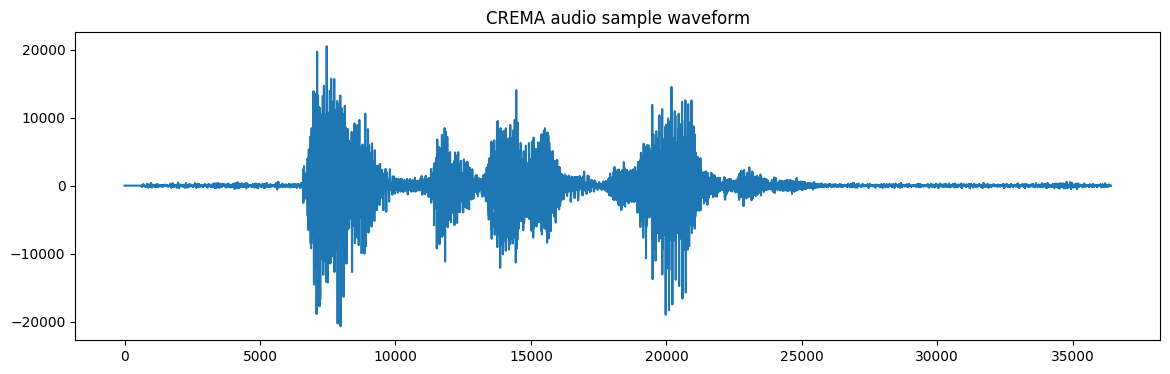

In [49]:
#sample audio in the CREMA_D Dataset
rate, x = scipy.io.wavfile.read(audio_data[0])
sound(x, rate, label='CREMA audio sample')
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('CREMA audio sample waveform')
plt.show()

filtered_temp_rec


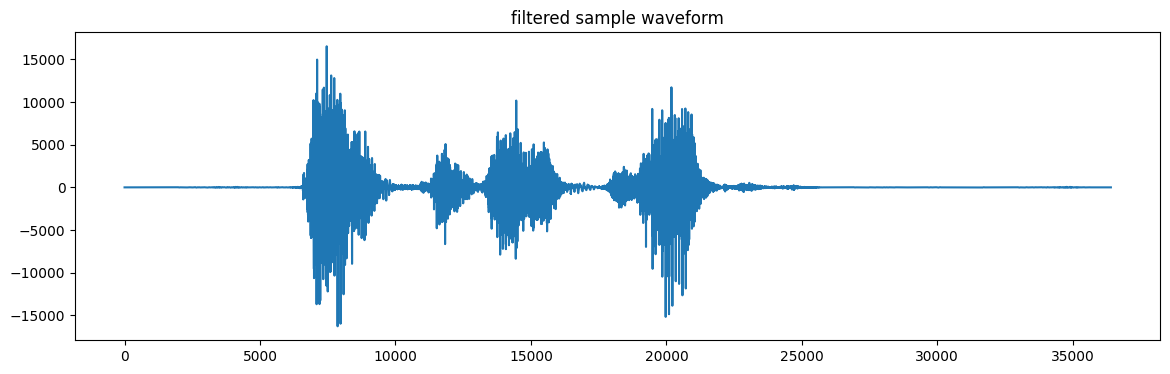

In [50]:
#filtering the audio due to noise using noise reduction
import noisereduce as nr
temp_rec = audio_data[0]
rate, data = wavfile.read(temp_rec)
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write('filtered_temp_rec.wav', rate, reduced_noise)
sound(reduced_noise, rate, label='filtered_temp_rec')
plt.figure(figsize=(14,4))
plt.plot(reduced_noise)
plt.title('filtered sample waveform')
plt.show()

Hear, I am trying to get the emotions files in dataset from the filenames by parsing them, and appended the extracted paths and emotions to respective lists. Then, constructed two pandas DataFrames: one for emotions and another for file paths. These DataFrames are then concatenated to form a single DataFrame, Crema_df, which contains both the path and emotion label for each audio file.

In [51]:
CREMA = '/content/drive/My Drive/Crema_Datasets/AudioWAV/'
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(CREMA + file)
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,/content/drive/My Drive/Crema_Datasets/AudioWA...
1,disgust,/content/drive/My Drive/Crema_Datasets/AudioWA...
2,fear,/content/drive/My Drive/Crema_Datasets/AudioWA...
3,happy,/content/drive/My Drive/Crema_Datasets/AudioWA...
4,neutral,/content/drive/My Drive/Crema_Datasets/AudioWA...


In [52]:
Crema_df.to_csv("CREMA-D.csv",index=False)
Crema_df

,Emotions,Path
0,angry,/content/drive/My Drive/Crema_Datasets/AudioWA...
1,disgust,/content/drive/My Drive/Crema_Datasets/AudioWA...
2,fear,/content/drive/My Drive/Crema_Datasets/AudioWA...
3,happy,/content/drive/My Drive/Crema_Datasets/AudioWA...
4,neutral,/content/drive/My Drive/Crema_Datasets/AudioWA...
...,...,...
7437,disgust,/content/drive/My Drive/Crema_Datasets/AudioWA...
7438,fear,/content/drive/My Drive/Crema_Datasets/AudioWA...
7439,happy,/content/drive/My Drive/Crema_Datasets/AudioWA...
7440,neutral,/content/drive/My Drive/Crema_Datasets/AudioWA...


###Data Visualization

In Data Visualization, I am trying to show the distribution of count of emotions in the dataset. Plotting the waveforms and the spectrograms of the audio files. I tried showing Visualization of 'fear', 'happy', 'sad' emotion audio recording

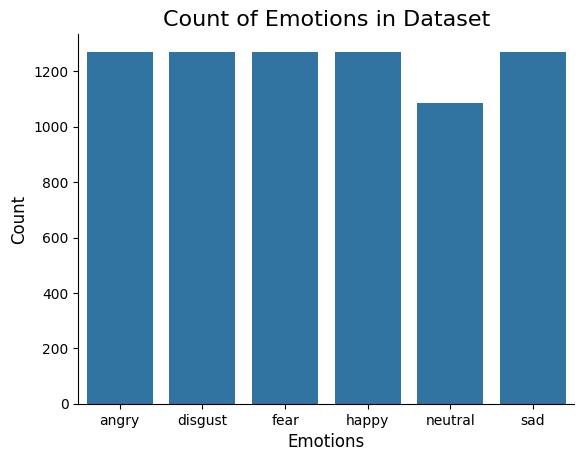

In [54]:
plt.title('Count of Emotions in Dataset', size=16)
sns.countplot(x=Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [55]:
path = np.array(Crema_df.Path[Crema_df.Emotions=='fear'])[1]
path

'/content/drive/My Drive/Crema_Datasets/AudioWAV/1001_IEO_FEA_HI.wav'

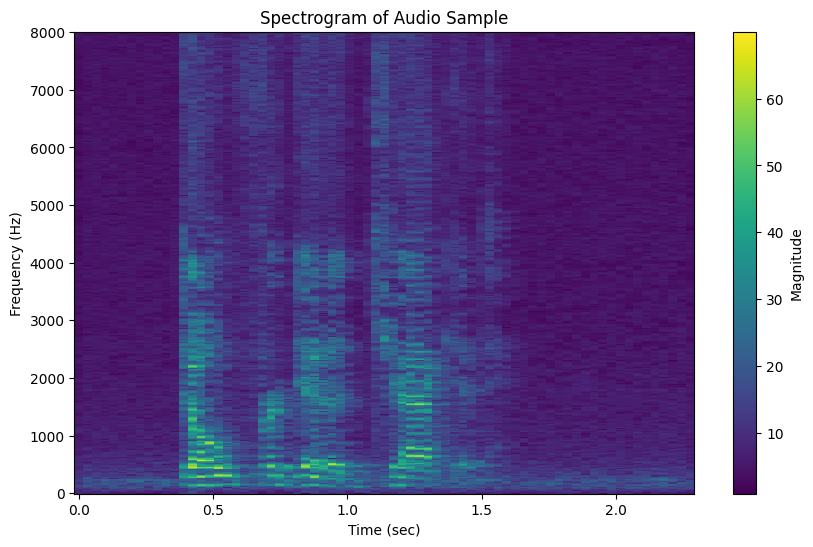

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram(input_sound, freq_rate, label):
    dft_size = 1024
    hop_size = 512
    window = np.hanning(dft_size)
    sound_length = len(input_sound)
    segments = []
    i = 0
    while i + dft_size < sound_length:
        segment = input_sound[i:i + dft_size]
        segments.append(np.multiply(segment, window))
        i += hop_size
    if i < sound_length:
        padding = np.zeros(i + dft_size - sound_length)
        segment = np.append(input_sound[i:], padding)
        segments.append(np.multiply(segment, window))
    frames = np.array(segments)
    dft_frames = np.array([np.fft.rfft(frame) for frame in frames], dtype=complex)
    magnitude_output = np.abs(dft_frames) ** 0.3
    x_axis = np.linspace(0, len(input_sound) / freq_rate, num=len(magnitude_output))
    max_freq = np.max(np.fft.rfftfreq(dft_size, d=1/freq_rate))
    y_axis = np.linspace(0, max_freq, num=magnitude_output.shape[1])
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(x_axis, y_axis, magnitude_output.T, shading='auto')
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Magnitude")
    plt.title(label)
    plt.show()

plot_spectrogram(data, rate, 'Spectrogram of Audio Sample')




CREMA audio Fear


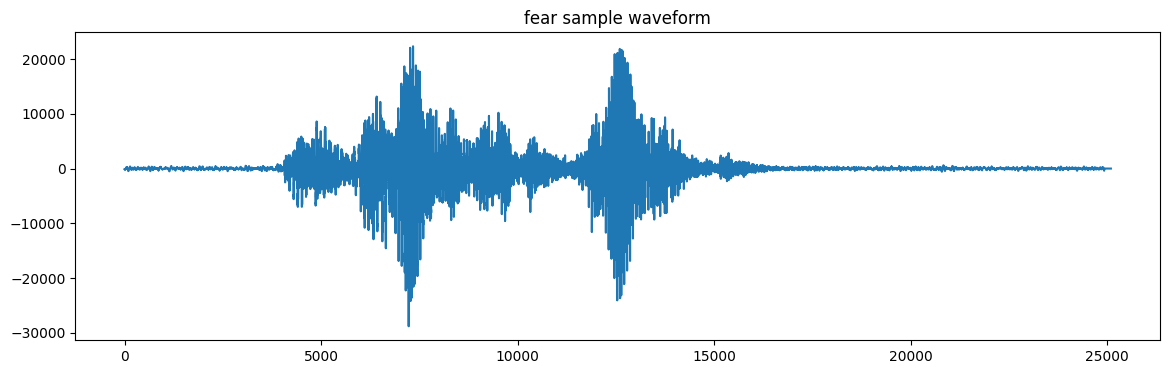

In [57]:
#Visualizing a 'fear' emotion audio recording
emotion = 'fear'
path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[1]
rate1, data_fear = scipy.io.wavfile.read(path)
sound(data_fear, rate1, label='CREMA audio Fear')
plt.figure(figsize=(14,4))
plt.plot(data_fear)
plt.title('fear sample waveform')
plt.show()

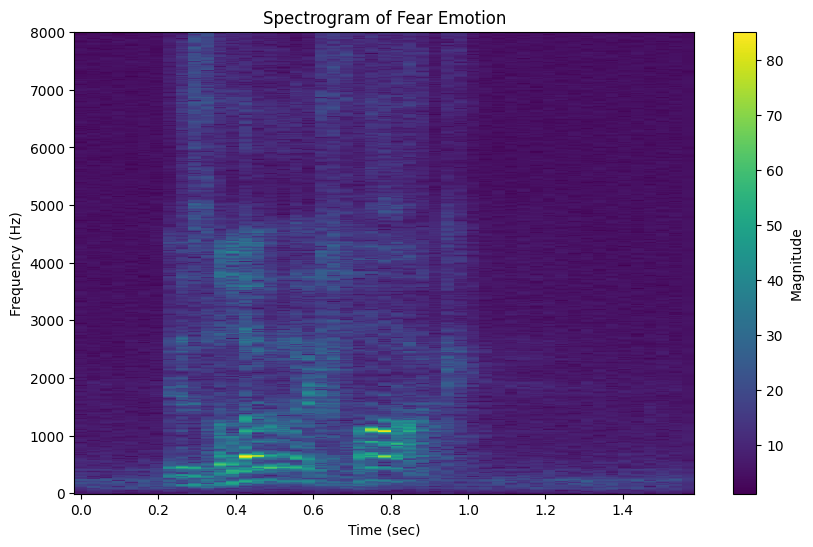

In [58]:
plot_spectrogram(data_fear, rate1, 'Spectrogram of Fear Emotion')


CREMA audio Sad


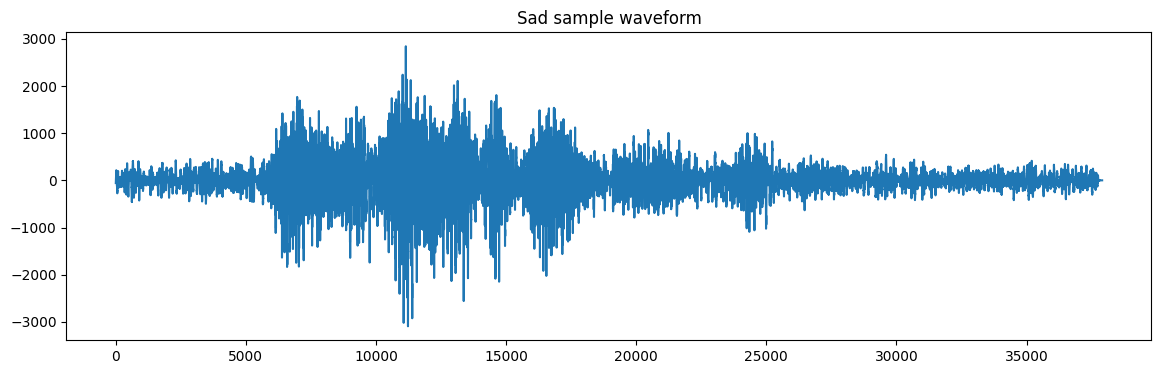

In [72]:
#Visualizing a 'sad' emotion audio recording
emotion = 'sad'
path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[5]
rate2, data_sad = scipy.io.wavfile.read(path)
# print(path)
sound(data_sad, rate2, label='CREMA audio Sad')
plt.figure(figsize=(14,4))
plt.plot(data_sad)
plt.title('Sad sample waveform')
plt.show()

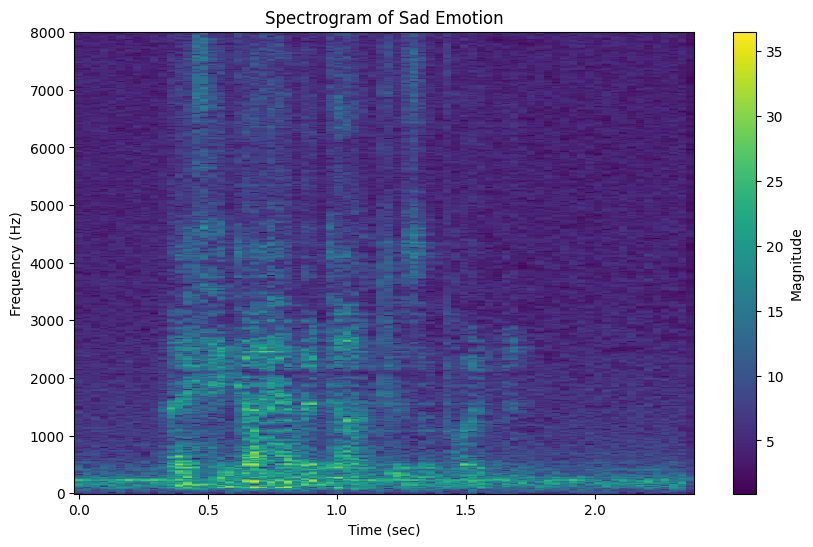

In [73]:
plot_spectrogram(data_sad, rate2, 'Spectrogram of Sad Emotion')

/content/drive/My Drive/Crema_Datasets/AudioWAV/1001_TAI_ANG_XX.wav


CREMA audio angry


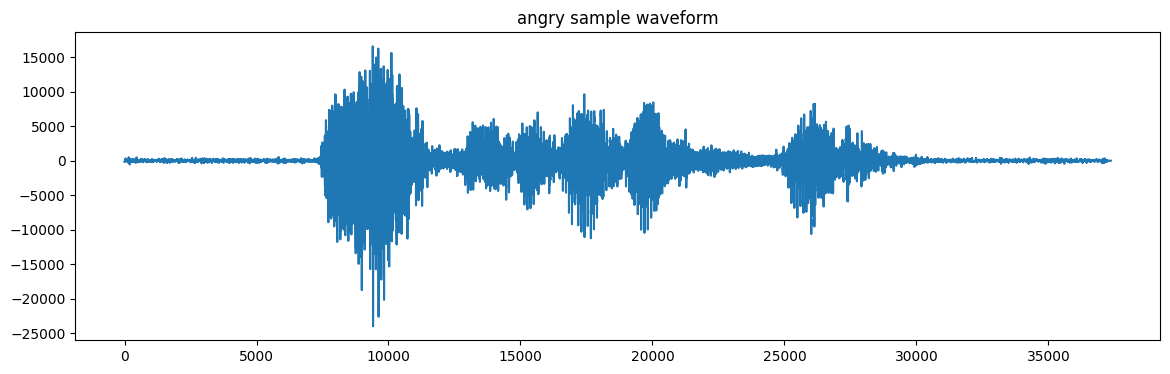

In [69]:
#Visualizing a 'angry' emotion audio recording
emotion = 'angry'
path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[10]
rate3, data_angry = scipy.io.wavfile.read(path)
print(path)
sound(data_angry, rate3, label='CREMA audio angry')
plt.figure(figsize=(14,4))
plt.plot(data_angry)
plt.title('angry sample waveform')
plt.show()

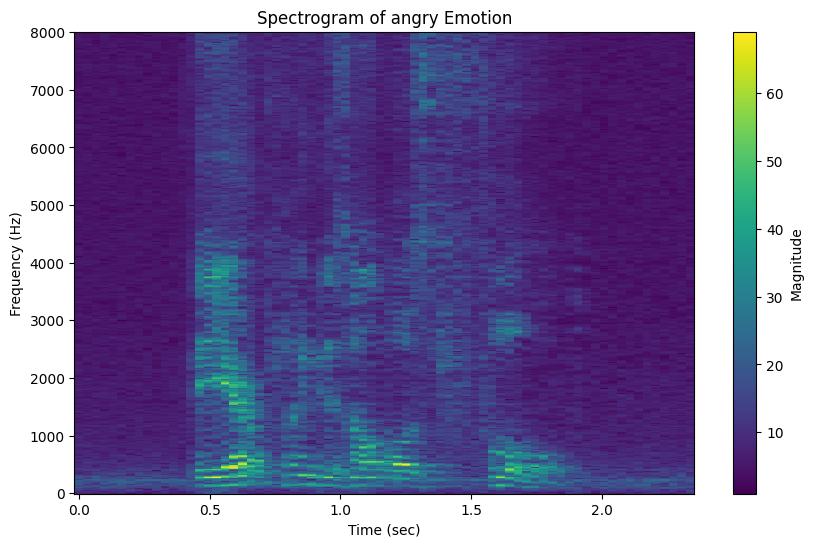

In [71]:
plot_spectrogram(data_angry, rate3, 'Spectrogram of angry Emotion')

###Data Augmentation

Performed audio data augmentation techniques such as adding noise, stretching time, shifting, and pitch alteration to enhance the diversity of audio data for machine learning applications. This approach is useful for preparing robust training datasets for audio-related tasks, such as speech and emotion recognition, ensuring the model's effectiveness across varied audio inputs.

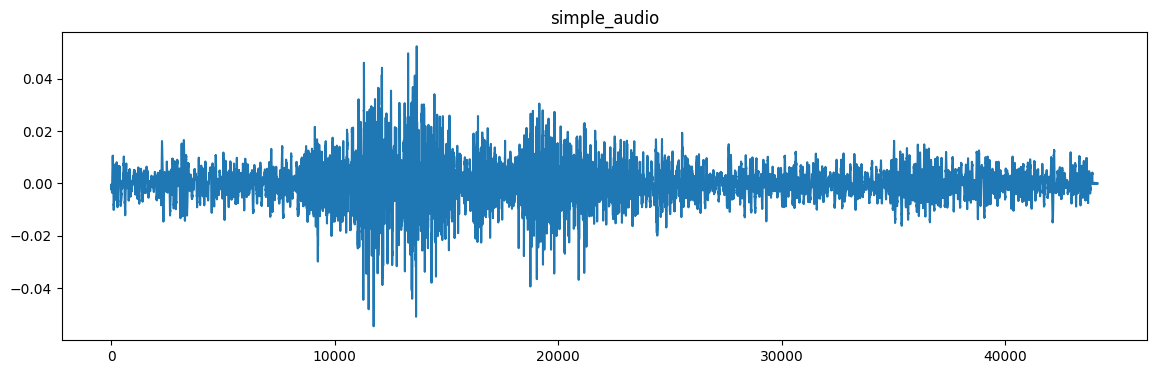

In [109]:
import librosa
# Defining functions for augmentation techniques
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=int(pitch_factor * 12))

def stretch(data, rate=0.6):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)



# taking an example and checking for techniques.
path = np.array(Crema_df.Path)[10]
SAMPLE_RATE = 22050
data, _ = librosa.load(path, sr=SAMPLE_RATE)
# Sample audio
plt.figure(figsize=(14,4))
plt.plot(data)
plt.title('simple_audio')
Audio(path)


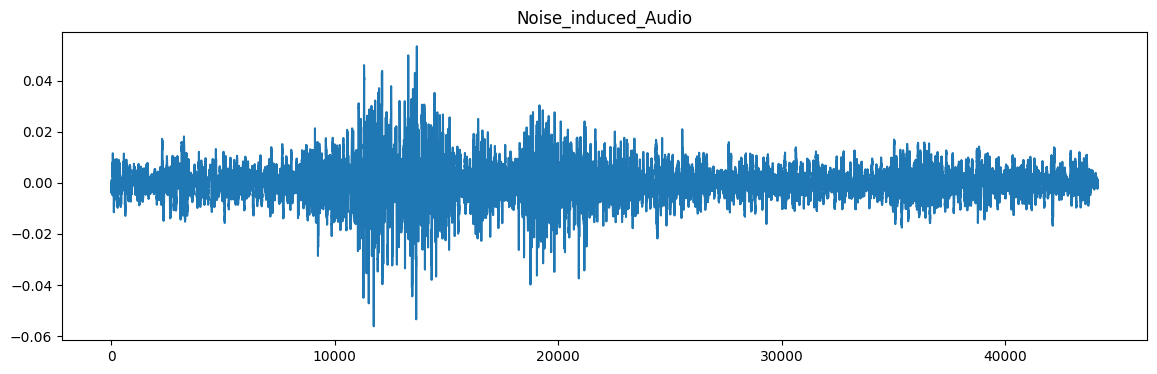

In [110]:
#Injecting Noise
x = noise(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Noise_induced_Audio')
Audio(x, rate= SAMPLE_RATE)


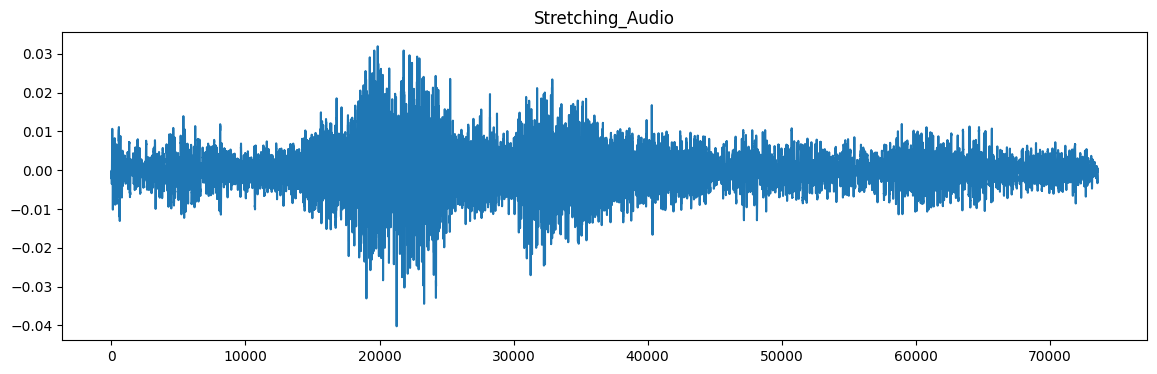

In [111]:
#stretching
x = stretch(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Stretching_Audio')
Audio(x, rate= SAMPLE_RATE)


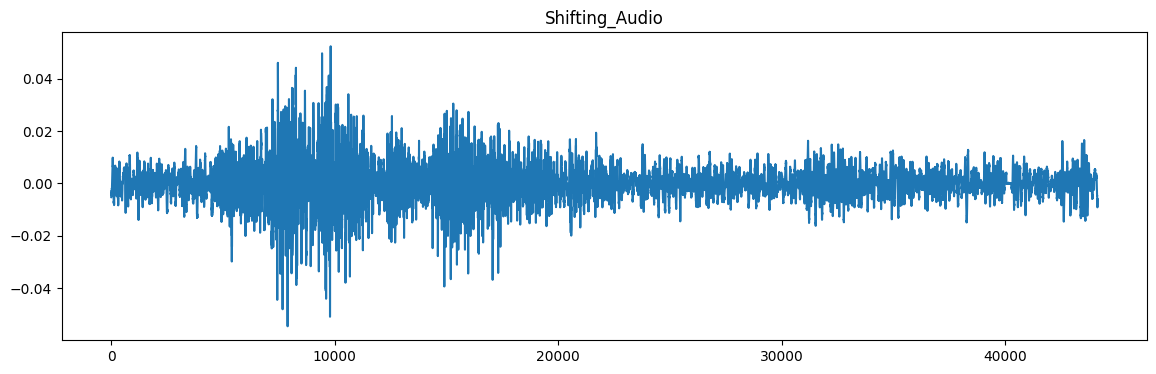

In [112]:
#shifting
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Shifting_Audio')
Audio(x, rate= SAMPLE_RATE)

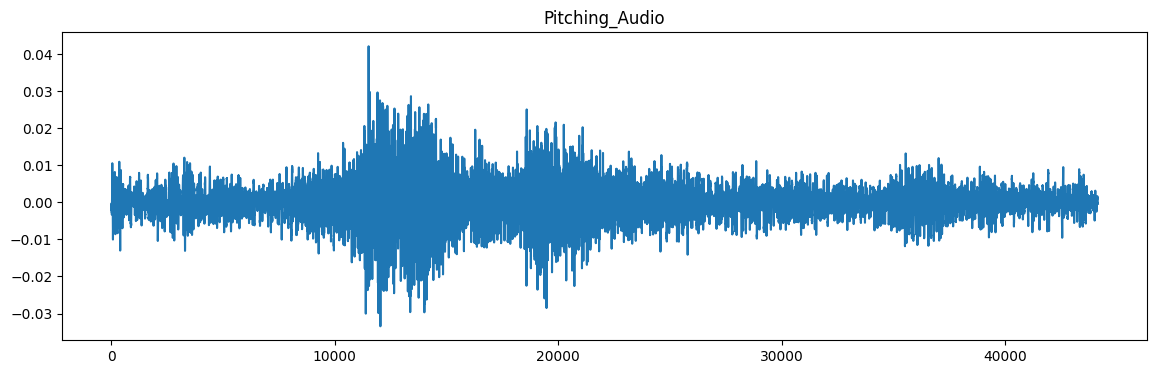

In [113]:
#pitching
x = pitch(data, SAMPLE_RATE)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Pitching_Audio')
Audio(x, rate= SAMPLE_RATE)


###Feature Extraction

Performing feature extraction using mfcc, zero crossing rate, root mean square.

I achieved feature extraction by processesing audio data to extract several key audio features. Specifically, it computes the Zero Crossing Rate (ZCR), Chroma Short-Time Fourier Transform (Chroma STFT), Mel-Frequency Cepstral Coefficients (MFCCs), Root Mean Square (RMS) value, and Mel Spectrogram from the audio signal. Each of these features captures different aspects of the sound, such as pitch, frequency, and amplitude characteristics, which are crucial for audio analysis.

In [114]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=SAMPLE_RATE).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=SAMPLE_RATE).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectrogram for the training of model
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=SAMPLE_RATE).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return np.array(result)


In [115]:
def load_file(path):
    data, _ = librosa.load(path, duration=2.5, offset=0.6, sr=SAMPLE_RATE)
    return data

In [116]:
def augment_and_extract_features(path):
    data = load_file(path)

    # without augmentation
    res1 = extract_features(data)
    result = np.vstack((np.array(res1), ))

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, SAMPLE_RATE)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result


In [117]:
#dividing dataset to training and testing sets
from tqdm import tqdm

X_path, y_emotion = Crema_df.Path, Crema_df.Emotions
x_train_path, x_test_path, y_train_emotion, y_test_emotion = train_test_split(X_path, y_emotion, random_state=0, shuffle=True)

X_train, y_train = [], []
for path, emotion in tqdm(zip(x_train_path, y_train_emotion)):
    feature = augment_and_extract_features(path)
    for ele in feature:
        X_train.append(ele)
        y_train.append(emotion)

X_test, y_test = [], []
for path, emotion in tqdm(zip(x_test_path, y_test_emotion)):
    feature = augment_and_extract_features(path)
    for ele in feature:
        X_test.append(ele)
        y_test.append(emotion)



5581it [33:51,  2.75it/s]
1861it [11:08,  2.79it/s]


this processes each audio file in the training and testing sets to augment and extract relevant features (like MFCCs or Chroma features). The extracted features and their corresponding emotion labels are stored in lists (x_train, y_train, x_test, y_test). Each audio feature extracted is appended to a feature list, and the associated emotion is appended to a label list.

####Data Preparation

Prepared data for a multiclass classification problem by applying one-hot encoding to transform the categorical labels into binary vectors using OneHotEncoder. It then scales the feature data using StandardScaler to ensure features have a mean of zero and a variance of one, optimizing them for machine learning algorithms. Finally, the data is reshaped to meet the input requirements of specific models, adding an additional dimension to the feature sets to make them compatible with models that expect a specific input shape for neural networks.

In [118]:
# As this is a multiclass classification problem onehot encoding your Y.
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [119]:
# Scaling data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16743, 162), (16743, 6), (5583, 162), (5583, 6))

In [120]:
# Making data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
x_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16743, 162, 1), (16743, 6), (5583, 162), (5583, 6))

###Modelling

Using CNNs, Sequential model.

Defined a convolutional neural network (CNN) using TensorFlow and Keras for sequence data processing, suitable for tasks like audio or time-series analysis. The network structure includes multiple layers of 1D convolutions and max pooling to extract and downsample features, interspersed with dropout layers to reduce overfitting. The model has fully connected layers and uses softmax activation for multiclass classification, compiling with the Adam optimizer and categorical crossentropy loss to optimize for accuracy.

In [121]:
print(X_train.shape)


(16743, 162, 1)


In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [123]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, verbose=0, min_lr=0.0000001)
history= model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])


Epoch 1/50
262/262 [==============================] - 137s 517ms/step - loss: 1.6012 - accuracy: 0.3158 - val_loss: 1.5113 - val_accuracy: 0.3604 - lr: 0.0010
Epoch 2/50
262/262 [==============================] - 126s 483ms/step - loss: 1.5189 - accuracy: 0.3544 - val_loss: 1.4916 - val_accuracy: 0.3792 - lr: 0.0010
Epoch 3/50
262/262 [==============================] - 126s 481ms/step - loss: 1.4943 - accuracy: 0.3715 - val_loss: 1.4614 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 4/50
262/262 [==============================] - 133s 509ms/step - loss: 1.4716 - accuracy: 0.3873 - val_loss: 1.4523 - val_accuracy: 0.4059 - lr: 0.0010
Epoch 5/50
262/262 [==============================] - 122s 468ms/step - loss: 1.4586 - accuracy: 0.3904 - val_loss: 1.4339 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 6/50
262/262 [==============================] - 120s 457ms/step - loss: 1.4324 - accuracy: 0.4038 - val_loss: 1.4478 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 7/50
262/262 [==========================

In [124]:
#predicting on test data
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

175/175 [==============================] - 18s 100ms/step


In [129]:
df = pd.DataFrame(columns = ['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(30)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,neutral,neutral
2,neutral,neutral
3,happy,neutral
4,neutral,neutral
5,disgust,neutral
6,happy,disgust
7,happy,disgust
8,happy,disgust
9,neutral,happy


While the model is able to predict few of the emotions like 'fear', 'neutral', and 'disgust'. However, it is also wrongly classifying other emotions like 'sad', 'happy', etc.

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.58      0.54      0.56       924
     disgust       0.34      0.36      0.35       930
        fear       0.44      0.33      0.38       963
       happy       0.36      0.40      0.38       963
     neutral       0.37      0.38      0.38       798
         sad       0.51      0.58      0.55      1005

    accuracy                           0.43      5583
   macro avg       0.44      0.43      0.43      5583
weighted avg       0.44      0.43      0.43      5583



Performing model testing for understand how the model is performing if it is able to classify emotions based on the audio features sent with their emotion labels.

Conclusion: For the emotion classifier, the model is run on various batch size and epochs settings


run1 -> batch = 5, epochs = 30, accuracy=32.22%

run2 -> batch = 15, epochs = 50, accuracy = 43.19%

run3 -> batch = 40, epoch = 45, accuracy = 56.65%

run4 -> batch = 70, epoch = 50, accuracy =48.50%

run5 -> batch = 64, epoch = 64, accuracy = 71.39%


From this i have achieved audio intent classification but emotion classifier could have been better as several more runs and hyperparameter tuning is required to achieve best results.